# Exploratory Analysis
***

## Background

Determine the degree of consensus in contentious academic fields. 

Collect title, publication date and summaries from scholarly articles containing a certain keyword or keywords. Apply NLP models to this data to identify and categorise concepts in this field and determine statistical significance between opposing 'truths', if any. Ranking these groups according to weighted influence will prove the degree of consensus of various approaches in a given academic field.

To this end the academic_consensus model has already searched the abstracts of academic papers that contain the keyword "nutrition" and saved it into corpus_raw.csv.  
  
Overview of this notebook:
- Setup notebok environment and load data (corpus_raw.csv)
- Review articles published per year (sklearn's Countvectorizer)
- Create Bag Of Words (BOW) of all articles for Titles and Conclusions (nltk)
- Create interactive BOW per year with Bokeh

## Setup

### Packages and setup

In [1]:
# Common
import pandas as pd
import matplotlib.pyplot as plt

# Complete BOW requirements
from collections import Counter
from collections import defaultdict
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS

# Animated BOW over time
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer

# Workspace
from IPython.core.interactiveshell import InteractiveShell

In [2]:
# Bokeh
from bokeh.io import output_notebook, show, push_notebook
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, Slider
from ipywidgets import interact

In [3]:
# Set workspace
sns.set()
# Set output charackters to 110 (not 79)
pd.options.display.width = 110
# To give multiple cell output. Not just the last command.
InteractiveShell.ast_node_interactivity = 'last'

### Load and inspect corpus.csv

In [4]:
# Load corpus.csv as DataFrame with parsed date format
corpus = pd.read_csv('../data/interim/corpus_raw.csv', parse_dates=[0])

In [5]:
# Keyword 
keywords = ['nutrition', 'diet']

In [6]:
# Inspect
corpus.info()
corpus.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1530 entries, 0 to 1529
Data columns (total 3 columns):
publication_date    1530 non-null datetime64[ns, UTC]
title               1530 non-null object
conclusions         1530 non-null object
dtypes: datetime64[ns, UTC](1), object(2)
memory usage: 36.0+ KB


,publication_date,title,conclusions
0,2016-03-09 00:00:00+00:00,Pregnancy Requires Major Changes in the Qualit...,['Pregnancy tends to markedly widen the nutrit...
1,2016-08-23 00:00:00+00:00,Continental-Scale Patterns Reveal Potential fo...,"['In all, given the geographic patterns in die..."
2,2015-06-17 00:00:00+00:00,Assessing Nutritional Parameters of Brown Bear...,['Previous studies have illustrated the differ...
3,2015-04-17 00:00:00+00:00,The Self-Reported Clinical Practice Behaviors ...,['The present study provides a valuable insigh...
4,2017-10-09 00:00:00+00:00,The impact of nutritional supplement intake on...,['Our study shows that the propensity to consu...


## Articles published per year

In [7]:
# Convert all 'title' text to a list of documents
text_title = list(corpus['title'])

In [8]:
# Use CountVectorizer on all titles
vect = CountVectorizer(stop_words='english', token_pattern='(?u)\\b\\w\\w+\\b')
# Convert to document-term matrix
text_dtm = vect.fit_transform(text_title)

#(?u)\\b\\w\\w+\\b  - regex standard
#\\b[^\\d\\W]+\\b   - regex to exclude digits everywhere
# co2|[^\\d\\W]+    - regex to exclude digits except "co2"

In [9]:
# Convert to dataframe
df_title = pd.DataFrame(text_dtm.toarray(), columns=vect.get_feature_names())
# Add the published date column set it as index
df_title['publication_date'] = corpus['publication_date']
df_title = df_title.set_index(['publication_date'])

In [10]:
# Create a new dataframe with a temporary column
df_article_year = df_title.copy()
df_article_year['###counter###'] = 1
# Groupby year
df_article_year = df_article_year.resample('Y').sum()
# Extract year only from publication_date
df_article_year['year_of_date'] = df_article_year.index
df_article_year['year_of_date'] = pd.to_datetime(df_article_year['year_of_date']).dt.year
# Reset index and select counter only
article_year = df_article_year.set_index(['year_of_date'])['###counter###']

Text(0.5, 1.0, 'Number of articles with Titles containing keyword "nutrition, diet".')

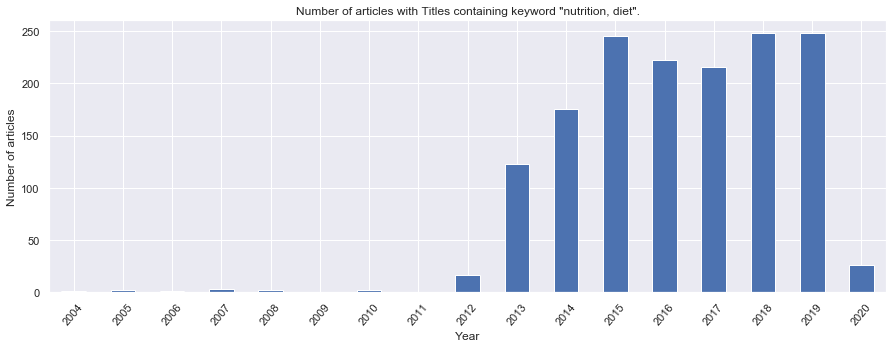

In [13]:
# Bar plot

plt.figure(figsize=(15,5))
article_year.plot(kind='bar')
plt.xticks(rotation=50);
plt.xlabel('Year')
plt.ylabel('Number of articles')
plt.title('Number of articles with Titles containing keyword "{}".'.format(', '.join(keywords)))

## Complete BOW of all articles

### BOW for article's Titles

In [14]:
# Select 'titles' from DataFrame
titles = corpus['title']
titles_dict = dict(titles)

In [15]:
# Function to prepare text data
# tokenize, lowercase, minus numbers, minus stopwords, lemmatised

def text_cleaning(row_text):
    ''' Prepare row of text and convert to BOW'''
    tokens = word_tokenize(row_text)
    lower_tokens = [t.lower() for t in tokens]
    alpha_only = [t for t in lower_tokens if t.isalpha()]
    no_stops = [t for t in alpha_only if t not in stopwords.words('english')]
    
    wordnet_lemmatizer = WordNetLemmatizer()
    lemmatized = [wordnet_lemmatizer.lemmatize(t) for t in no_stops]
    return lemmatized

In [16]:
# Create a list of all tokens
tokens_all =[]
for key, row_text in titles_dict.items():
    row_text_clean = text_cleaning(row_text)
    [tokens_all.append(word) for word in row_text_clean]
print('Done')

Done


Text(0.5, 1.0, 'Bag of Words for article Titles with keyword "nutrition, diet" with 30 most apearing words')

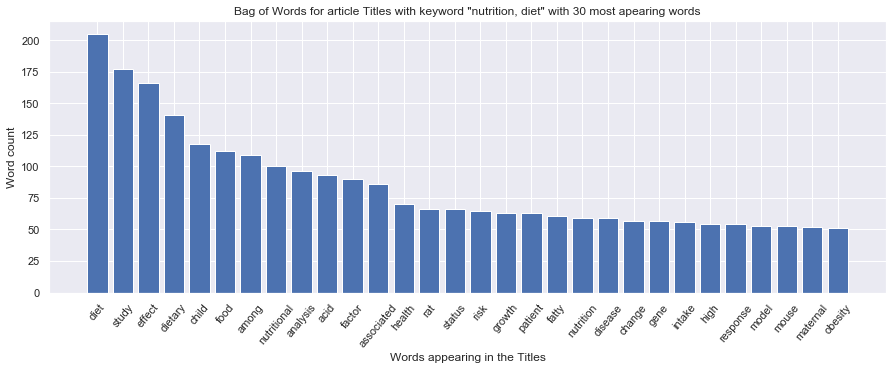

In [19]:
# Create Bag Of Words from all tokens
bow = Counter(tokens_all)
# Convert dictionary for ease of plotting
bow_dict = dict(bow.most_common(30))
# Plot
plt.figure(figsize=(15,5))
plt.bar(bow_dict.keys(), bow_dict.values())
plt.xticks(rotation=50);
plt.xlabel('Words appearing in the Titles')
plt.ylabel('Word count')
plt.title('Bag of Words for article Titles with keyword "{}" with 30 most apearing words'.format(', '.join(keywords)))

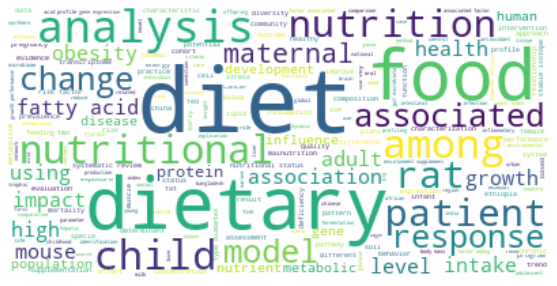

In [20]:
# Create one continuous string of words to use 'wordcloud'
tokens_all_str = ''
for word in tokens_all:
    tokens_all_str += ' ' + word
    
# add redundant stopwords
stopwords_bow = set(STOPWORDS)
stopwords_bow.update(['effect', 'study'])
wordcloud = WordCloud(background_color='white', stopwords=stopwords_bow).generate(tokens_all_str)

# Display the generated image
plt.figure(figsize=(15,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### BOW for article's Conclusions

In [21]:
# Select 'conclusions' from DataFrame
concl = corpus['conclusions']
concl_dict = dict(concl)

In [24]:
# Function to prepare text data
# tokenize, lowercase, minus numbers, minus stopwords, lemmatised

def text_cleaning(row_text):
    ''' Prepare row of text and convert to BOW'''
    tokens = word_tokenize(row_text)
    lower_tokens = [t.lower() for t in tokens]
    alpha_only = [t for t in lower_tokens if t.isalpha()]
    no_stops = [t for t in alpha_only if t not in stopwords.words('english')]
    
    wordnet_lemmatizer = WordNetLemmatizer()
    lemmatized = [wordnet_lemmatizer.lemmatize(t) for t in no_stops]
    return lemmatized

In [25]:
# Create a list of all tokens
print('This can take more than a minute...')
tokens_all =[]
for key, row_text in concl_dict.items():
    row_text_clean = text_cleaning(row_text)
    [tokens_all.append(word) for word in row_text_clean]
print('Done')

Done


Text(0.5, 1.0, 'Bag of Words for article Conclusions with keyword "nutrition, diet"           with 30 most apearing words')

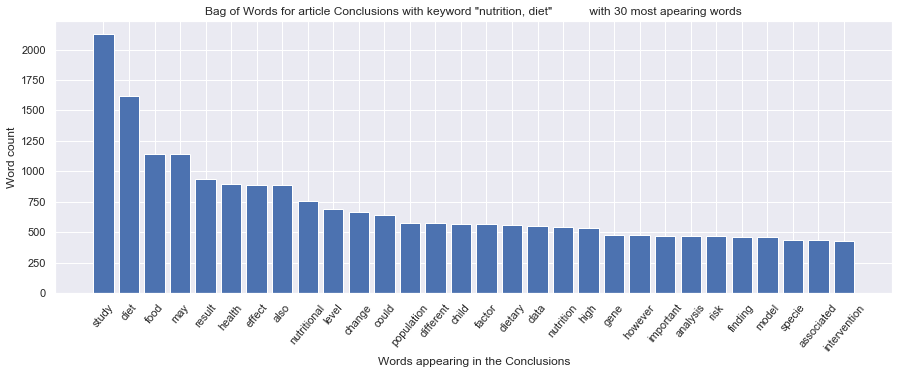

In [26]:
# Create Bag Of Words from all tokens
bow = Counter(tokens_all)
# Convert dictionary for ease of plotting
bow_dict = dict(bow.most_common(30))
# Plot
plt.figure(figsize=(15,5))
plt.bar(bow_dict.keys(), bow_dict.values())
plt.xticks(rotation=50);
plt.xlabel('Words appearing in the Conclusions')
plt.ylabel('Word count')
plt.title('Bag of Words for article Conclusions with keyword "{}" \
          with 30 most apearing words'.format(', '.join(keywords)))

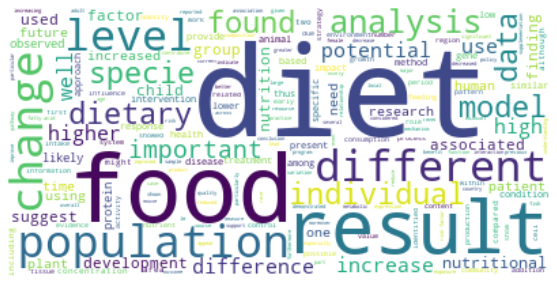

In [27]:
# Create one continuous string of words to use 'wordcloud'
tokens_all_str = ''
for word in tokens_all:
    tokens_all_str += ' ' + word
    
# add redundant stopwords
stopwords_bow = set(STOPWORDS)
stopwords_bow.update(['effect', 'study', 'may'])
wordcloud = WordCloud(background_color='white', stopwords=stopwords_bow).generate(tokens_all_str)

# Display the generated image
plt.figure(figsize=(15,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Interactive BOW per year

### 'Titles'

In [28]:
# Order df_title features from most occuring words to least
# Group by year
df_title = df_title.resample('Y').sum()
# Get index of top 50 most occuring features
index_most_features = df_title.resample('100Y').sum().iloc[1].sort_values(ascending=False).keys()
# Convert to list
index_most_features = list(index_most_features)
# Re-order columns and select only top 50 words
df_title = df_title[index_most_features[:25]]

In [29]:
output_notebook()

Loading BokehJS ...

In [30]:
# Bokeh plot for a given year
# Initial conditions
start_year = df_title.index.min().year
end_year = df_title.index.max().year
#val = start_year
# Values
words = list(df_title.columns)
count = df_title[str(start_year)].values[0]
year = start_year

In [31]:
# First plot
pl = figure(x_range=words, plot_height=350, y_range=(0,30), title='Word Count for Titles')
dat = pl.vbar(x=words, top=count, width=0.9)
pl.xgrid.grid_line_color = None
pl.y_range.start = 0
pl.xaxis.major_label_orientation = 3.14/4

In [32]:
# Updating the plot from the slider
def update_plot(year):
    dat.data_source.data['top'] = df_title[str(year)].values[0]
    push_notebook()

In [33]:
# Show plot with slider
show(pl, notebook_handle=True)
interact(update_plot, year=(start_year, end_year, 1));

interactive(children=(IntSlider(value=2012, description='year', max=2020, min=2004), Output()), _dom_classes=(…

### 'Conclusions'

In [34]:
# Convert all 'title' text to a list of documents
text_concl = list(corpus['conclusions'])

In [35]:
# Use CountVectorizer on all titles
vect = CountVectorizer(stop_words='english', token_pattern='(?u)\\b\\w\\w+\\b')
# Convert to document-term matrix
text_dtm = vect.fit_transform(text_concl)

#(?u)\\b\\w\\w+\\b  - regex standard
#\\b[^\\d\\W]+\\b   - regex to exclude digits everywhere
# co2|[^\\d\\W]+    - regex to exclude digits except "co2"

In [36]:
# Convert to dataframe
df_concl = pd.DataFrame(text_dtm.toarray(), columns=vect.get_feature_names())
# Add the published date column set it as index
df_concl['publication_date'] = corpus['publication_date']
df_concl = df_concl.set_index(['publication_date'])

In [37]:
# Order df_cocnl features from most occuring words to least
# Group by year
df_concl = df_concl.resample('Y').sum()
# Get index of top 50 most occuring features
index_most_features = df_concl.resample('100Y').sum().iloc[1].sort_values(ascending=False).keys()
# Convert to list
index_most_features = list(index_most_features)
# Re-order columns and select only top 50 words
df_concl = df_concl[index_most_features[:25]]

In [38]:
output_notebook()

Loading BokehJS ...

In [39]:
# Bokeh plot for a given year
# Initial conditions
start_year = df_concl.index.min().year
end_year = df_concl.index.max().year
#val = start_year
# Values
words = list(df_concl.columns)
count = df_concl[str(start_year)].values[0]
year = start_year

In [49]:
# First plot
pl = figure(x_range=words, plot_height=350, y_range=(0,300), title='Word Count for Conclusions')
dat = pl.vbar(x=words, top=count, width=0.9)
pl.xgrid.grid_line_color = None
pl.y_range.start = 0
pl.xaxis.major_label_orientation = 3.14/4

In [50]:
# Updating the plot from the slider
def update_plot(year):
    dat.data_source.data['top'] = df_concl[str(year)].values[0]
    push_notebook()

In [51]:
# Show plot with slider
show(pl, notebook_handle=True)
interact(update_plot, year=(start_year, end_year, 1));

interactive(children=(IntSlider(value=2012, description='year', max=2020, min=2004), Output()), _dom_classes=(…